In [1]:
import os
import coincident
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np

/panfs/ccds02/nobackup/people/sbhusha1/sw/coincident/src/coincident/io/download.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/panfs/ccds02/nobackup/people/sbhusha1/sw/coincident/src/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


## Attempt 1: Use Coincident example

In [3]:
gdf_ncalm = gpd.read_file('20250722_PCD_ncalm_sfm_footprints.geojson')
gdf_fourway = gpd.read_file('20250722_PCD_ncalm_fourway_overlap.geojson')
gdf_stereo = gpd.read_file('20250722_PCD_ncalm_stereo_footprints.geojson')

In [4]:
gdf_proc_extent = gpd.GeoDataFrame(geometry=[box(*gdf_fourway.total_bounds)],
                                    crs=gdf_fourway.crs)

<Axes: >

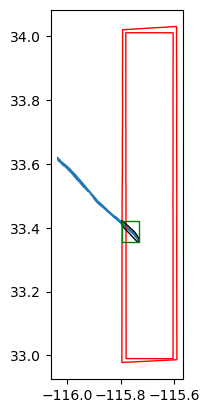

In [5]:
f,ax = plt.subplots()
gdf_ncalm.plot(ax=ax)
gdf_stereo.plot(ax=ax,facecolor='None',edgecolor='r')
gdf_fourway.plot(ax=ax,facecolor='None',edgecolor='k')
gdf_proc_extent.plot(ax=ax,facecolor='None',edgecolor='green')

In [9]:
output_dir = '/panfs/ccds02/nobackup/people/sbhusha1/pcd/ncalm/sa_fault/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [6]:
gf_ncalm = coincident.search.search(
    dataset="ncalm", intersects=gdf_proc_extent, datetime=["2020-02-15"]
)

In [18]:
coincident.io.download.download_ncalm_dem(
    aoi=tapped_bounds,
    dataset_id=gf_ncalm["name"].item(),
    product='dsm',
    output_dir=output_dir)

NoDataInBounds: No data found in bounds.

#### This was returning an error of No data found in bounds. 

#### I then ended up finding the location of the vrt data on s3 and process from there for lack of time

In [38]:
vrt_fn = '/vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh.vrt'
!gdalinfo $vrt_fn

Driver: VRT/Virtual Raster
Files: /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh.vrt
       /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh/SSAF_v12cOT_10cmDSM_ITRF14-2020.1-epsg32611_ellhts-12-11.tif
       /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh/SSAF_v12cOT_10cmDSM_ITRF14-2020.1-epsg32611_ellhts-16-18.tif
       /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh/SSAF_v12cOT_10cmDSM_ITRF14-2020.1-epsg32611_ellhts-5-5.tif
       /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh/SSAF_v12cOT_10cmDSM_ITRF14-2020.1-epsg32611_ellhts-19-19.tif
       /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh/SSAF_v12cOT_10cmDSM_ITRF14-2020.1-epsg32611_ellhts-13-14.tif
       /vsicurl/https://opentopography.s3.sdsc.edu/raster/CA21_Bunds/CA21_Bunds_hh/SSAF_v12cOT_10cmDSM_ITRF14-2020.1-epsg32611_ellhts-5-6.tif
       /vsicurl/https://op

#### Import some lidar_tools geo-processing functions

In [15]:
def nearest_floor(x: int | float, a: int | float) -> int | float:
    """
    Round down to the nearest smaller multiple of a.
    """
    return np.floor(x / a) * a


def nearest_ceil(x: int | float, a: int | float) -> int | float:
    """
    Round down to the nearest larger multiple of a.
    """
    return np.ceil(x / a) * a


def tap_bounds(site_bounds: tuple | list | np.ndarray, res: int | float) -> list:
    """
    calculate target aligned pixel bounds for a given site bounds and resolution.

    Parameters
    ----------
    site_bounds:
        array of bounds with the following order [minx, miny, maxx, maxy]
    res:
        resolution in same units of site_bounds

    Returns
    -------
    target_aligned_bounds: list[float]
        Adjusted bounds such that extent is a multiple of resolution

    Notes
    -----
    - From https://github.com/uw-cryo/EarthLab_AirQuality_UAV/blob/main/notebooks/EarthLab_AQ_lidar_download_processing_function.ipynb
    - See also https://gdal.org/en/stable/programs/gdalwarp.html#cmdoption-gdalwarp-tap
    """
    return [
        nearest_floor(site_bounds[0], res),
        nearest_floor(site_bounds[1], res),
        nearest_ceil(site_bounds[2], res),
        nearest_ceil(site_bounds[3], res),
    ]

from osgeo import gdal,gdalconst
def gdal_add_overview(raster_fn: str,ensure_cog=True) -> None:
    """
    Add Gaussian overviews to a raster file using GDAL.
    Converts the raster to a COG, 
        as adding Gaussian overviews added to tiled and compressed rasters does not automatically ensure COG compliance

    Parameters
    ----------
    raster_fn : str
        Path to the raster file.
    ensure_cog : bool, optional
        Whether to ensure the output raster is a COG, by default True.
    """
    print(f"Adding Gaussian overviews to {raster_fn}")
    with gdal.OpenEx(raster_fn, 1, open_options=["IGNORE_COG_LAYOUT_BREAK=YES"]) as ds:
        gdal.SetConfigOption("COMPRESS_OVERVIEW", "DEFLATE")
        ds.BuildOverviews(
            "GAUSS", [2, 4, 8, 16, 32, 64], callback=gdal.TermProgress_nocb
        )
    
    if ensure_cog:
        temp_fn =Path(raster_fn).parent / f"{Path(raster_fn).stem}-cop-temp.tif"
        gdal.Translate(
            str(temp_fn),
            raster_fn,
            format="COG",
            creationOptions=["OVERVIEWS=FORCE_USE_EXISTING","BIGTIFF=IF_SAFER"],
            callback=gdal.TermProgress_nocb,
        )
        rename_rasters(str(temp_fn), raster_fn)


def gdal_warp(
    src_fn: str,
    dst_fn: str,
    src_srs: str,
    dst_srs: str,
    res: float = 1.0,
    resampling_alogrithm: str = "bilinear",
    out_extent: list = None,
) -> None:
    """
    Warp a raster file to a new coordinate reference system and resolution using GDAL.
    Parameters
    ----------
    src_fn : str
        Path to the source raster file.
    dst_fn : str
        Path to the destination raster file.
    src_srs : str
        Source coordinate reference system in WKT format.
    dst_srs : str
        Destination coordinate reference system in WKT format
    res : float, optional
        Resolution for the output raster, by default 1.0.
    resampling_alogrithm : str, optional
        Resampling algorithm to use, by default 'cubic'.
    out_extent : list, optional
        The extent of the output raster in the format [minx, miny, maxx, maxy], by default None.
    Returns 
    ------
    None
    This function does not return anything, it writes the output raster to the specified file.
    """
    tolerance = 0
    resampling_mapping = {
        "nearest": gdalconst.GRA_NearestNeighbour,
        "bilinear": gdalconst.GRA_Bilinear,
        "cubic": gdalconst.GRA_Cubic,
        "cubic_spline": gdalconst.GRA_CubicSpline,
    }
    resampling_alg = resampling_mapping[resampling_alogrithm]

    ds = gdal.Warp(
        dst_fn,
        src_fn,
        resampleAlg=resampling_alg,
        srcSRS=src_srs,
        xRes=res,
        yRes=res,
        dstSRS=dst_srs,
        errorThreshold=tolerance,
        targetAlignedPixels=True,
        # use directly output format as COG when gaussian overview resampling is implemented upstream in GDAL
        outputBounds=out_extent,
        creationOptions=["COMPRESS=LZW", "TILED=YES", "COPY_SRC_OVERVIEWS=YES","BIGTIFF=IF_SAFER"],
        callback=gdal.TermProgress_nocb,
    )
    ds.Close()
def rename_rasters(raster_fn,out_fn) -> None:
    """
    Rename the raster file to the final output name and the associated XML file if it exists.
    Parameters
    ----------
    raster_fn : str
        Path to the raster file to be renamed.
    out_fn : str
        Path to the output raster file name.
    Returns
    -------
    None
    This function does not return anything, it renames the raster file and its associated XML file
    """
    raster_path = Path(raster_fn)
    xml_fn = raster_fn + ".aux.xml"
    Path(raster_fn).rename(out_fn)
    if Path(xml_fn).exists():
        out_fn_xml = out_fn + ".aux.xml"
        Path(xml_fn).rename(out_fn_xml)

In [56]:

tapped_bounds_native = gpd.GeoDataFrame(
    geometry=[box(*tap_bounds(gdf_proc_extent.to_crs('EPSG:32611').total_bounds,res=0.1))],
    crs='EPSG:32611')
tapped_bounds_1m = gpd.GeoDataFrame(
    geometry=[box(*tap_bounds(gdf_proc_extent.to_crs('EPSG:32611').total_bounds,res=1.0))],
    crs='EPSG:32611')

In [74]:
output_fn = os.path.join(output_dir,'ncalm_sa_fault_dsm_native_res.tif')

In [63]:
minx,miny,maxx,maxy = tapped_bounds_native.total_bounds

In [65]:
out_extent = [minx,maxy,maxx,miny]
gdal.Translate(output_fn,vrt_fn,
               projWin=out_extent,
               creationOptions=["COMPRESS=LZW", "TILED=YES"],
               callback=gdal.TermProgress_nocb)

100 - done in 00:04:16.
0...10...20...30...40...50...60...70...80...90...

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x146aba7f87e0> >

In [69]:
gdal_add_overview(output_fn)

Adding Gaussian overviews to /panfs/ccds02/nobackup/people/sbhusha1/pcd/ncalm/sa_fault/ncalm_sa_fault_dsm_native_res.tif
100 - done in 00:04:03.
0...10...20...30...40...50...60...70...80...90...100 - done in 00:02:13.
0...10...20...30...40...50...60...70...80...90...

#### Project to UTM 11 G2139, 1 m resolution, and tapped extent

In [70]:
out_srs = '/panfs/ccds02/nobackup/people/sbhusha1/pcd/pcd_usgs_lpc_proc_total_bounds/CA_YosemiteNP_2019_processing/UTM_11N_WGS84_G2139_3D.wkt'

In [71]:
tapped_bounds_1m.total_bounds

array([ 612027., 3691225.,  618050., 3698803.])

In [73]:
output_fn_1m = os.path.join(output_dir,'ncalm_sa_fault_dsm_1m.tif')

In [77]:
gdal_warp(output_fn,
          output_fn_1m,
          'EPSG:32611',
          out_srs,
          1.0,
          'bilinear',
          out_extent = tapped_bounds_1m.total_bounds)

100 - done in 00:04:02.
0...10...20...30...40...50...60...70...80...90...

In [78]:
gdal_add_overview(output_fn_1m)

Adding Gaussian overviews to /panfs/ccds02/nobackup/people/sbhusha1/pcd/ncalm/sa_fault/ncalm_sa_fault_dsm_1m.tif
100 - done in 00:00:06.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...